(multilevel_modeling)=
# A Primer on Bayesian Methods for Multilevel Modeling

:::{post} 24 October, 2022
:tags: hierarchical model, case study 
:category: intermediate
:author: Chris Fonnesbeck, Colin Carroll, Alex Andorra, Oriol Abril, Farhan Reynaldo
:::

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

We will motivate this topic using an environmental epidemiology example.

## Example: Radon contamination {cite:t}`gelman2006data`

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](https://www.cgenarchive.org/uploads/2/5/2/6/25269392/7758459_orig.jpg)

The EPA did a study of radon levels in 80,000 houses. There are two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota.

The hierarchy in this example is households within county.

### Data organization

First, we import the data from a local file, and extract Minnesota's data.

In [1]:
import os

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

The original data exists as several independent datasets, which we will import, merge, and process here. First is the data on measurements from individual homes from across the United States. We will extract just the subset from Minnesota.

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

Next, obtain the county-level predictor, uranium, by combining two variables.

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data('cty.dat'))

srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st=='MN'].copy()
cty_mn['fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

Use the `merge` method to combine home- and county-level information in a single DataFrame.

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

Let's encode the county names and make local copies of the variables we will use.
We also need a lookup table (`dict`) for each unique county, for indexing.

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

Distribution of radon levels in MN (log scale):

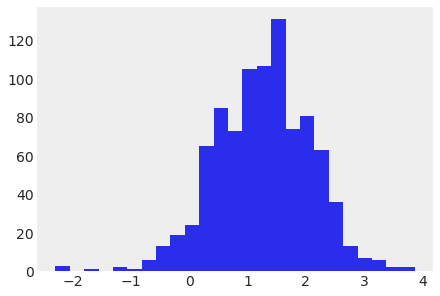

In [7]:
srrs_mn.log_radon.hist(bins=25, grid=False);

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

Here are the point estimates of the slope and intercept for the complete pooling model:

In [8]:
with pm.Model() as pooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")
    
    alpha = pm.Normal('alpha', 0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Exponential('sigma', 5)
    
    theta = alpha + beta*floor_ind
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon, dims="obs_id")
    

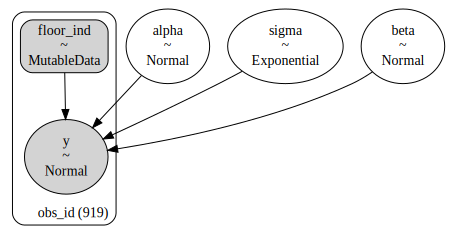

In [9]:
pm.model_to_graphviz(pooled_model)

You may be wondering why we are using the `pm.Data` container above even though the variable `floor_ind` is not an observed variable nor a parameter of the model. As you'll see, this will make our lives much easier when we'll plot and diagnose our model.ArviZ will thus include `floor_ind` as a variable in the `constant_data` group of the resulting {ref}`InferenceData <xarray_for_arviz>` object. Moreover, including `floor_ind` in the `InferenceData` object makes sharing and reproducing analysis much easier, all the data needed to analyze or rerun the model is stored there.

Before running the model let's do some **prior predictive checks**. 

Indeed, having sensible priors is not only a way to incorporate scientific knowledge into the model, it can also help and make the MCMC machinery faster -- here we are dealing with a simple linear regression, so no link function comes and distorts the outcome space; but one day this will happen to you and you'll need to think hard about your priors to help your MCMC sampler. So, better to train ourselves when it's quite easy than having to learn when it's very hard. 

There is a convenient function for prior predictive sampling in PyMC:

In [10]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, sigma, y]


ArviZ `InferenceData` uses `xarray.Dataset`s under the hood, which give access to several common plotting functions with `.plot`. In this case, we want scatter plot of the mean log radon level (which is stored in variable `a`) for each of the two levels we are considering. If our desired plot is supported by xarray plotting capabilities, we can take advantage of xarray to automatically generate both plot and labels for us. Notice how everything is directly plotted and annotated, the only change we need to do is renaming the y axis label from `a` to `Mean log radon level`.

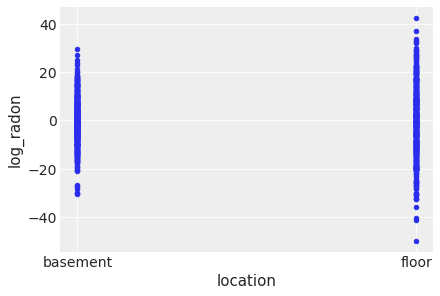

In [11]:
prior_alphas = prior_checks.prior.alpha.values.squeeze()
prior_betas = prior_checks.prior.beta.values.squeeze()

pd.concat([
    pd.DataFrame(dict(location='basement', log_radon=prior_alphas)),
    pd.DataFrame(dict(location='floor', log_radon=prior_alphas+prior_betas))
]).plot.scatter(x='location', y='log_radon');

I'm no radon expert, but before seeing the data, these priors seem to allow for quite a wide range of the mean log radon level, both as measured etiher in a basement or on a floor. But don't worry, we can always change these priors if sampling gives us hints that they might not be appropriate -- after all, priors are assumptions, not oaths; and as with most assumptions, they can be tested.

However, we can already think of an improvement: Remember that we stated radon levels tend to be higher in basements, so we could incorporate this prior scientific knowledge into our model by forcing the floor effect (`beta`) to be negative. For now, we will leave the model as is, and trust that the information in the data will be sufficient.

Speaking of sampling, let's fire up the Bayesian machinery!

In [12]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


No divergences and a sampling that only took seconds! Here the chains look very good (good R hat, good effective sample size, small sd). The model also estimated a negative floor effect, as we expected.

In [13]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.36,0.03,1.31,1.42,0.0,0.0,4200.11,3082.69,1.0
beta,-0.59,0.07,-0.73,-0.46,0.0,0.0,3944.89,3146.38,1.0
sigma,0.79,0.02,0.75,0.83,0.0,0.0,4816.77,3116.53,1.0


Let's plot the expected radon levels in basements (`alpha`) and on floors (`alpha + beta`) in relation to the data used to fit the model:

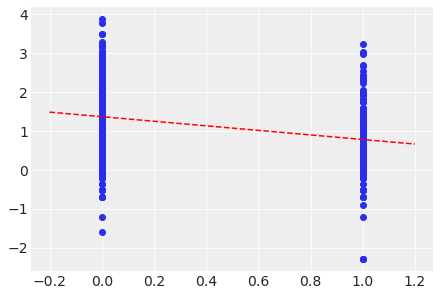

In [14]:
alpha_mean = pooled_trace.posterior.mean(dim=("chain", "draw")).alpha.values
beta_mean = pooled_trace.posterior.mean(dim=("chain", "draw")).beta.values

plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, beta_mean*xvals + alpha_mean, 'r--');

This looks reasonable, though notice that there is a great deal of residual variability in the data. 

Let's now turn our attention to the unpooled model, and see how it fares in comparison.

In [15]:
coords={'county': mn_counties}

with pm.Model(coords=coords) as unpooled_model:
    floor_idx = pm.MutableData("floor_ind", floor_measure, dims="obs_id")
    
    alpha = pm.Normal('alpha', 0, sigma=10, dims='county')
    beta = pm.Normal('beta', 0, sigma=10)
    sigma = pm.Exponential('sigma', 1)
    
    theta = alpha[county] + beta*floor_ind
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon, dims="obs_id")
    

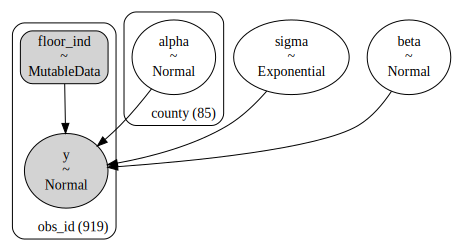

In [16]:
pm.model_to_graphviz(unpooled_model)

In [17]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The sampling was clean here too; Let's look at the expected values for both basement (dimension 0) and floor (dimension 1) in each county:

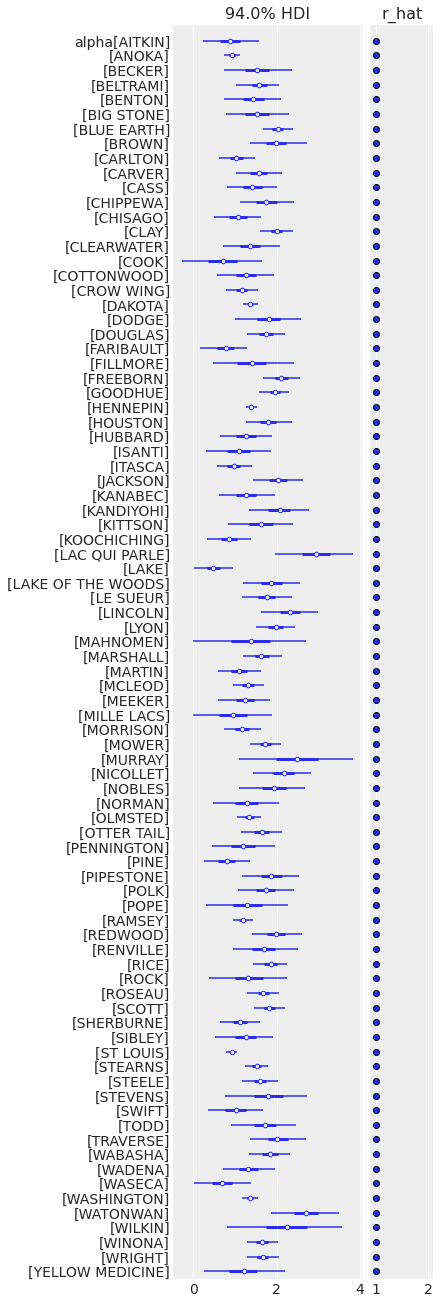

In [18]:
az.plot_forest(
    unpooled_trace, 
    var_names=['alpha'], 
    r_hat=True, 
    combined=True,
    figsize=(6,18)
);

To identify counties with high radon levels, we can plot the ordered mean estimates, as well as their 94% HPD:

In [19]:
unpooled_estimates = unpooled_trace.posterior.mean(dim=('chain', 'draw')).alpha
unpooled_se = unpooled_trace.posterior.std(dim=('chain', 'draw')).alpha

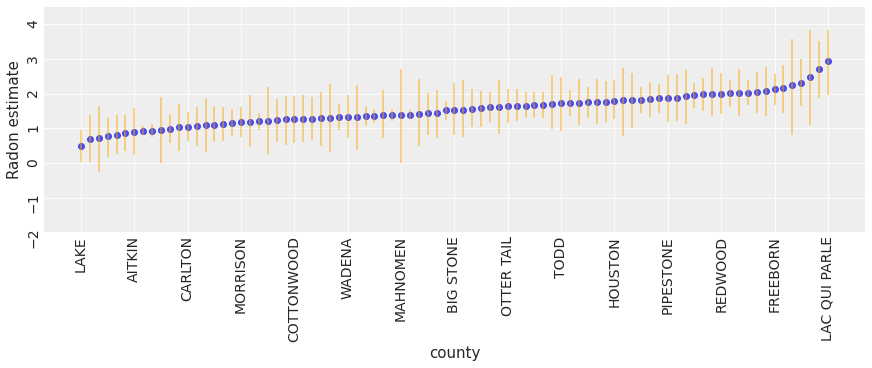

In [20]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12,5))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.size),
    unpooled_hdi_iter.alpha.sel(hdi="lower"),
    unpooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);

Now that we have fit both conventional (*i.e.* non-hierarchcial) models, let's see how their inferences differ. Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

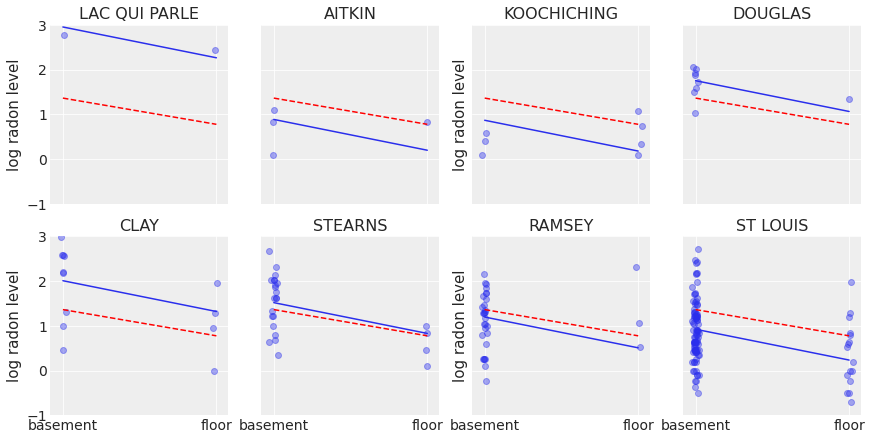

In [21]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace.posterior.mean(dim=("chain", "draw")).beta
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates.sel(county=c)
    
    # Plot both models and data
    xvals = np.linspace(0, 1)
    axes[i].plot(xvals, m.values*xvals+b.values)
    axes[i].plot(xvals, beta_mean*xvals+alpha_mean, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Neither of these models are satisfactory:

* If we are trying to identify high-radon counties, pooling is useless -- because, by definition, the pooled model estimates radon at the state-level. In other words, pooling leads to maximal *underfitting*: the variation across counties is not taken into account and only the overall population is estimated.
* We do not trust extreme unpooled estimates produced by models using few observations. This leads to maximal *overfitting*: only the within-county variations are taken into account and the overall population (i.e the state-level, which tells us about similarites across counties) is not estimated. 

This issue is acute for small sample sizes, as seen above: in counties where we have few floor measurements, if radon levels are higher for those data points than for basement ones (Aitkin, Koochiching, Ramsey), the model will estimate that radon levels are higher in floors than basements for these counties. But we shouldn't trust this conclusion, because both scientific knowledge and the situation in other counties tell us that it is usually the reverse (basement radon > floor radon). So unless we have a lot of observations telling us otherwise for a given county, we should be skeptical and shrink our county-estimates to the state-estimates -- in other words, we should balance between cluster-level and population-level information, and the amount of shrinkage will depend on how extreme and how numerous the data in each cluster are. 

Here is where hierarchical models come into play.

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance) -- we assume that counties are all the same:

![pooled](pooled_model.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that counties have no similarity whatsoever:

![unpooled](unpooled_model.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](partial_pooled_model.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average, while those for counties with larger sample sizes will be closer to the unpooled county estimates.

Let's start with the simplest model, which ignores the effect of floor vs. basement measurement.

In [22]:
with pm.Model(coords=coords) as partial_pooling:
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=10)
    sigma_a = pm.Exponential('sigma_a', 1)
    
    # Random intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='county')
    
    # Model error
    sigma_y = pm.Exponential('sigma_y',1)
    
    # Expected value
    y_hat = alpha[county_idx]
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")
    

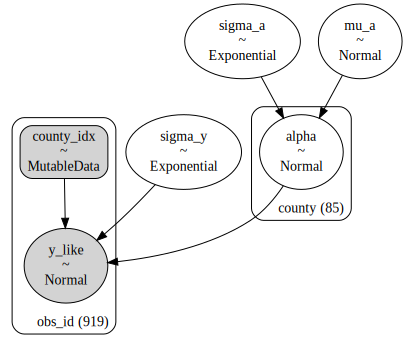

In [23]:
pm.model_to_graphviz(partial_pooling)

In [24]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, sigma_y]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


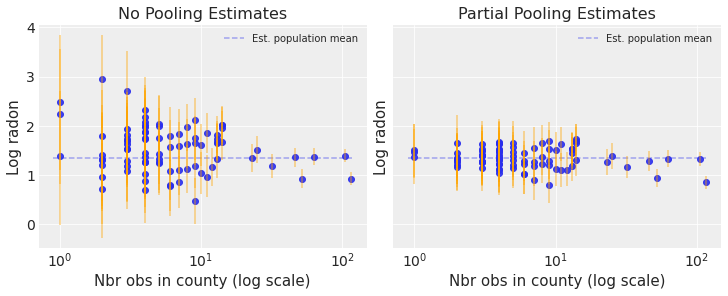

In [25]:
N_county = srrs_mn.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partial_pooling_trace),
    ("no pooling", "partial pooling"),
):

    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_county": ("county", N_county)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="alpha", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_trace.posterior.alpha.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).alpha
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size counties are informed by the population parameters -- hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) -- hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in counties where data is sparse. This is known as **shrinkage**.

Now let's go back and integrate the `floor` predictor, but allowing the intercept to vary by county.

## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [26]:
with pm.Model(coords=coords) as varying_intercept:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1)
    
    # Random intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='county')
    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # Model error
    sd_y = pm.Exponential('sd_y', 1)
    
    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=log_radon, dims="obs_id")
    

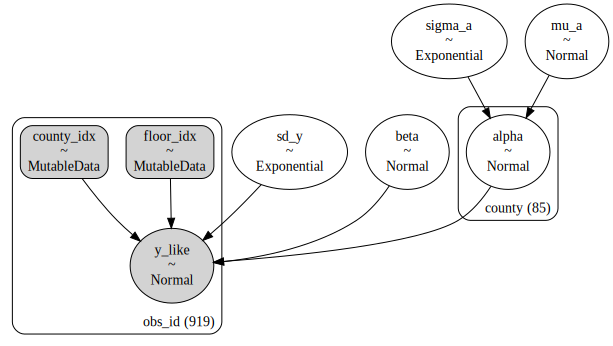

In [27]:
pm.model_to_graphviz(varying_intercept)

In [28]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, beta, sd_y]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


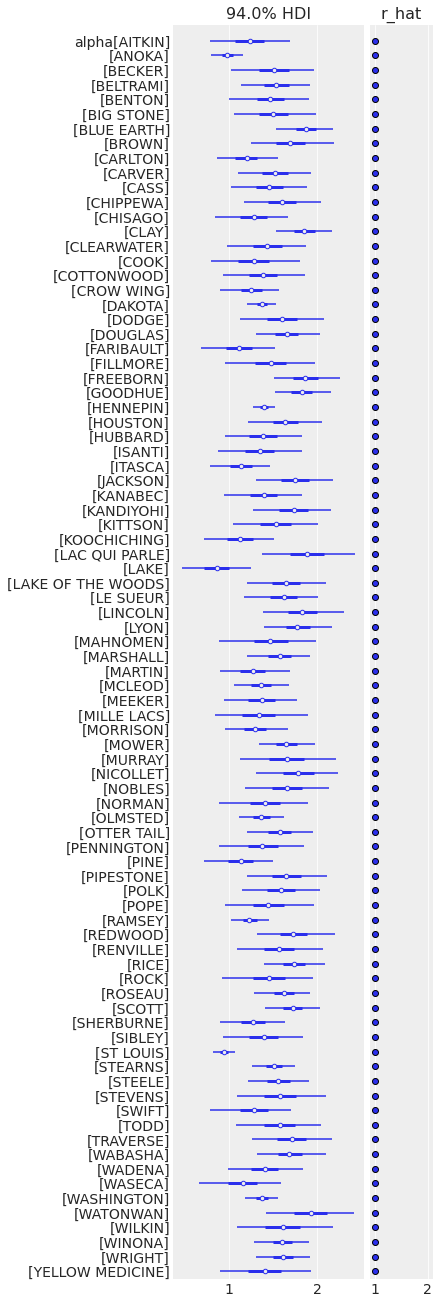

In [29]:
pm.plot_forest(varying_intercept_trace, var_names=['alpha'], figsize=(6,18), combined=True, r_hat=True);

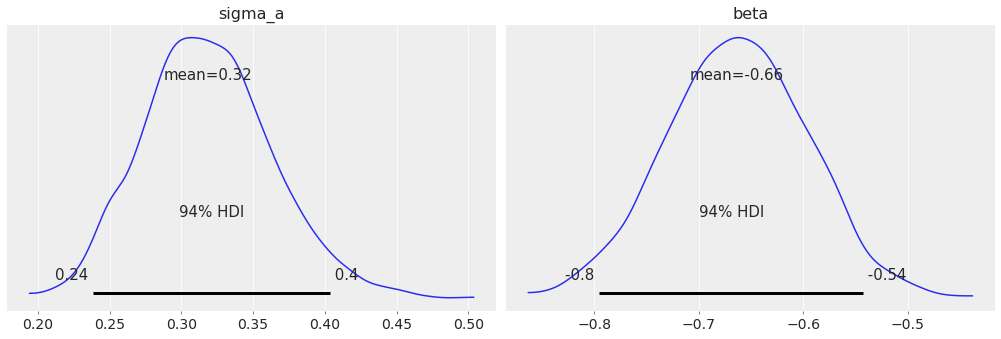

In [30]:
pm.plot_posterior(varying_intercept_trace, var_names=['sigma_a', 'beta']);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [31]:
az.summary(varying_intercept_trace, var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.664,0.067,-0.795,-0.543,0.001,0.001,3199.0,2981.0,1.0


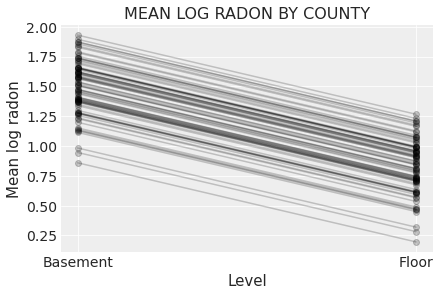

In [32]:
import xarray as xr

xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

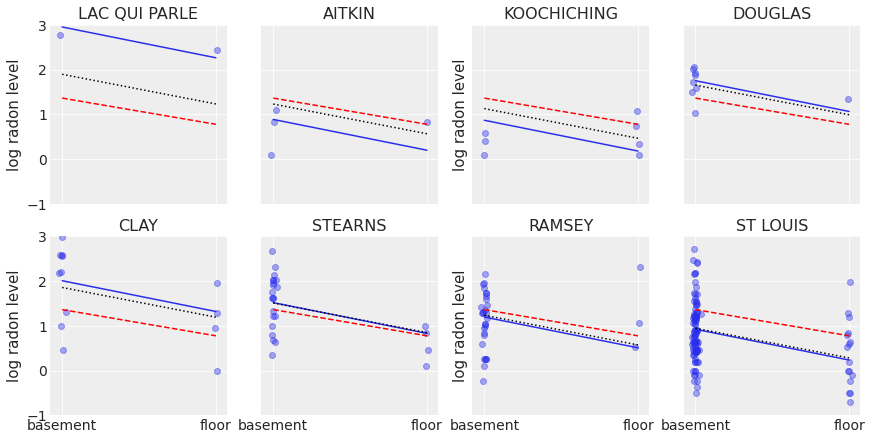

In [33]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace.posterior.mean(dim=("chain", "draw")).beta
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates.sel(county=c)
    
    # Plot both models and data
    xvals = np.linspace(0, 1)
    axes[i].plot(xvals, m.values*xvals+b.values)
    axes[i].plot(xvals, beta_mean*xvals+alpha_mean, 'r--')

    varying_intercept_trace.posterior.sel(county=c).beta
    post = varying_intercept_trace.posterior.sel(county=c).mean(dim=("chain", "draw"))
    theta = (
        post.alpha.values + post.beta.values * xvals
    )
    axes[i].plot(xvals, theta, 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [34]:
with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1)
    
    mu_b = pm.Normal('mu_b', mu=0., sigma=10.)
    sigma_b = pm.Exponential('sigma_b', 1)
    
    # Random intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='county')
    # Random slopes
    beta = pm.Normal('beta', mu=mu_b, sigma=sigma_b, dims='county')
    
    # Model error
    sigma_y = pm.Exponential('sigma_y', 1)
    
    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

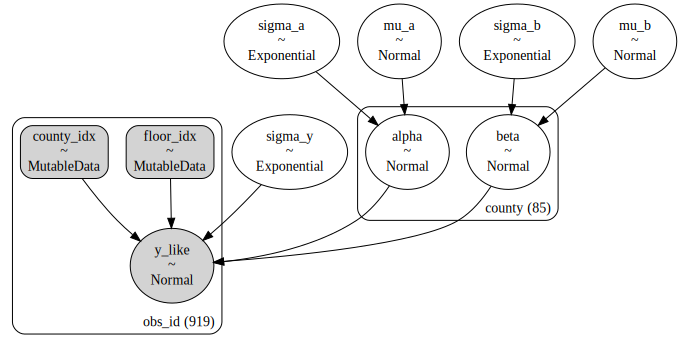

In [35]:
pm.model_to_graphviz(varying_intercept_slope)

In [36]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, alpha, beta, sigma_y]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


Notice that the trace of this model includes divergences, which can be problematic depending on where and how frequently they occur. These can occur is some hierararchical models, and they can be avoided by using the **non-centered parametrization**.

## Non-centered Parameterization

The partial pooling models specified above uses a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. As the preceding plot reveals, this constraint serves to **shrink** county estimates toward the overall mean, to a degree proportional to the county sample size. This is exactly what we want, and the model appears to fit well--the Gelman-Rubin statistics are exactly 1.

But, on closer inspection, there are signs of trouble. Specifically, let's look at the trace of the random effects, and their corresponding standard deviation:

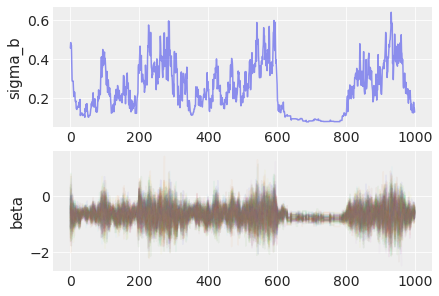

In [37]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_intercept_slope_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(varying_intercept_slope_trace.posterior.sel(chain=0)['beta'], alpha=.05);
axs[1].set(ylabel='beta');

Notice that when the chain reaches the lower end of the parameter space for $\sigma_b$, it appears to get "stuck" and the entire sampler, including the random slopes `b`, mixes poorly. 

Jointly plotting the random effect variance and one of the individual random slopes demonstrates what is going on.

/Users/cfonnesbeck/miniforge3/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


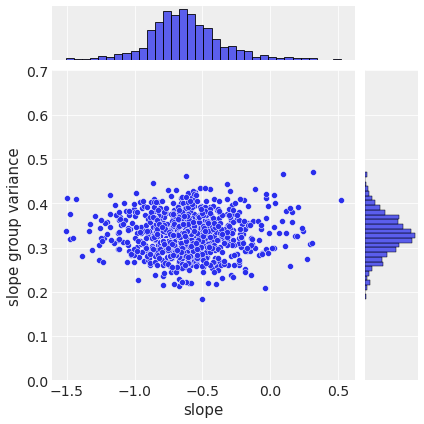

In [38]:
x = varying_intercept_slope_trace.posterior['beta'].sel(chain=0, county='AITKIN').to_series() 
x.name='slope'
y = varying_intercept_slope_trace.posterior['sigma_a'].sel(chain=0).to_series()
y.name='slope group variance'

jp = sns.jointplot(x=x, y=y, ylim=(0, .7));

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. This results in a *funnel*-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size). 

In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model. Notice the random slopes in this version:

In [39]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 5)
    
    # Non-centered random intercepts
    # Centered: a = pm.Normal('a', mu_a, sigma=sigma_a, shape=counties)
    z_a = pm.Normal('z_a', mu=0, sigma=1, dims='county')
    alpha = pm.Deterministic("alpha", mu_a + z_a * sigma_a, dims='county')

    mu_b = pm.Normal('mu_b', mu=0., sigma=10.)
    sigma_b = pm.Exponential('sigma_b', 5)
    
    # Non-centered random slopes
    z_b = pm.Normal('z_b', mu=0, sigma=1, dims='county')
    beta = pm.Deterministic("beta", mu_b + z_b * sigma_b, dims='county')
    
    # Model error
    sigma_y = pm.Exponential('sigma_y',5)
    
    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")
    

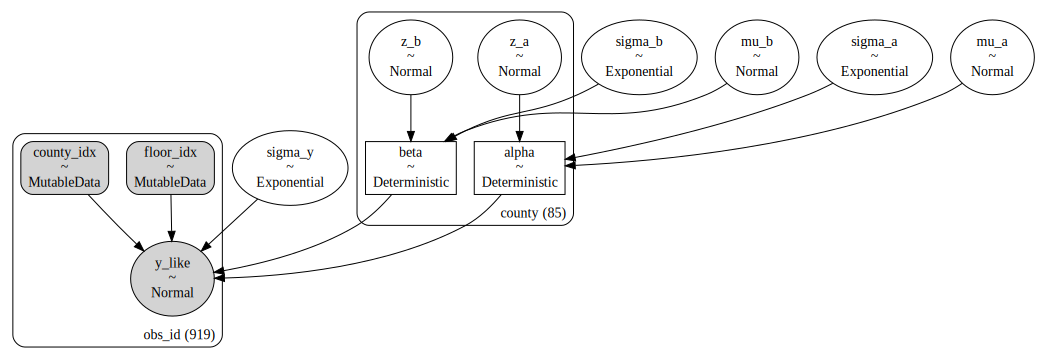

In [40]:
pm.model_to_graphviz(varying_intercept_slope_noncentered)

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

This model samples much better.

In [41]:
with varying_intercept_slope_noncentered:
    noncentered_trace = pm.sample(tune=3000, target_accept=.95, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, z_a, mu_b, sigma_b, z_b, sigma_y]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 17 seconds.


Notice that the bottlenecks in the traces are gone.|

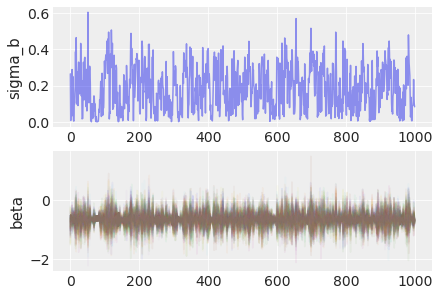

In [42]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(noncentered_trace.posterior.sel(chain=0)['beta'], alpha=.05);
axs[1].set(ylabel='beta');

And correspondingly, the low end of the posterior distribution of the slope random effect variance can now be sampled efficiently.

/Users/cfonnesbeck/miniforge3/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


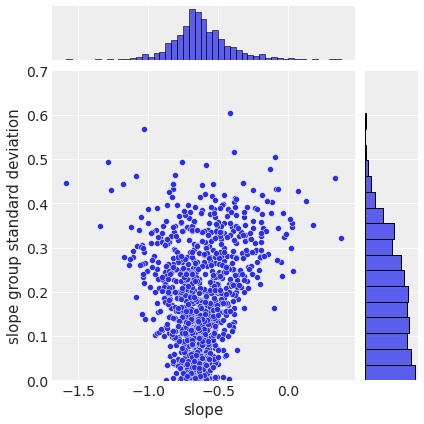

In [43]:
x = noncentered_trace.posterior['beta'].sel(chain=0, county='AITKIN').to_series() 
x.name='slope'
y = noncentered_trace.posterior['sigma_b'].sel(chain=0).to_series()
y.name='slope group standard deviation'

jp = sns.jointplot(x=x, y=y, ylim=(0, .7));

As a result, we are now fully exploring the support of the posterior. This results in less bias in these parameters.

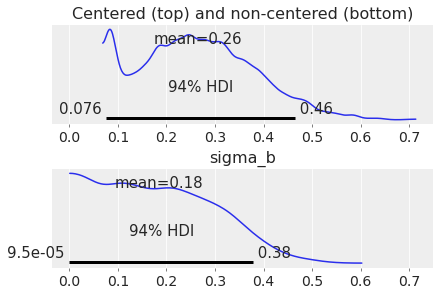

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_intercept_slope_trace, var_names=['sigma_b'], ax=ax1)
az.plot_posterior(noncentered_trace, var_names=['sigma_b'], ax=ax2)
ax1.set_title('Centered (top) and non-centered (bottom)');

Notice that `sigma_b` now has a lot of density near zero, which would indicate that counties don't vary that much in their answer to the `floor` "treatment". 

This was the problem with the original parameterization: the sampler has difficulty with the geometry of the posterior distribution when the values of the slope random effects are so different for standard deviations very close to zero compared to when they are positive. However, even with the non-centered model the sampler is not that comfortable with `sigma_b`: in fact if you look at the estimates with `az.summary` you'll see that the number of effective samples is quite low for `sigma_b`.

Also note that `sigma_a` is not that big either -- i.e counties do differ in their baseline radon levels, but not by a lot. However we don't have that much of a problem to sample from this distribution because it's much narrower than `sigma_b` and doesn't get dangerously close to 0.

In [45]:
az.summary(varying_intercept_slope_trace, var_names=['sigma_a', 'sigma_b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.327,0.044,0.241,0.409,0.001,0.001,926.0,1553.0,1.00
sigma_b,0.264,0.118,0.076,0.465,0.016,0.011,50.0,55.0,1.09


To wrap up this model, let's plot the relationship between radon and floor for each county:

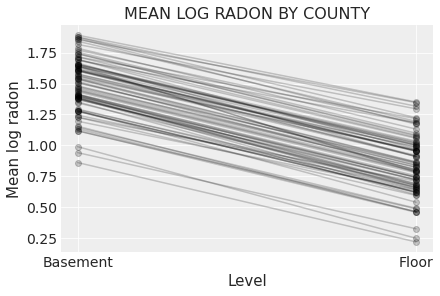

In [46]:
import xarray as xr

xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = noncentered_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

This, while both the intercept and the slope vary by county, there is far less variation in the slope. 

But wait, there is more! We can (and maybe should) take into account the covariation between intercepts and slopes: when baseline radon is low in a given county, maybe that means the difference between floor and basement measurements will decrease -- because there isn't that much radon anyway. That would translate into a positive correlation between `alpha` and `beta`, and adding that into our model would make even more efficient use the available data. 

To model this correlation, we'll use a multivariate Normal distribution instead of two different Normals for `alpha` and `beta`. This simply means that each county's parameters come from a common distribution with mean `mu_alpha` for intercepts and `mu_beta` for slopes, and slopes and intercepts co-vary according to the covariance matrix `S`. In mathematical form:

$$y \sim Normal(\theta, \sigma)$$

$$\theta = \alpha + \beta \times floor$$

$$\begin{bmatrix} \alpha \\ \beta \end{bmatrix} \sim MvNormal(\begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix}, \Sigma)$$

$$\Sigma = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}
     P
     \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}$$
     
where $\alpha$ and $\beta$ are the mean intercept and slope respectively, $\sigma_{\alpha}$ and $\sigma_{\beta}$ represent the variation in intercepts and slopes respectively, and $P$ is the correlation matrix of intercepts and slopes. In this case, as their is only one slope, $P$ contains only one relevant figure: the correlation between $\alpha$ and $\beta$.

This translates quite easily in PyMC:

In [47]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # prior for average intercept:
    mu_alpha_beta = pm.Normal("mu_alpha", mu=0.0, sigma=5.0, shape=2)
    # prior for average slope:
    mu_beta = pm.Normal("mu_beta", mu=0.0, sigma=1.0)
    # population of varying effects:
    alpha_beta_county = pm.MvNormal("alpha_beta_county", mu=mu_alpha_beta, chol=chol, dims=("county", "param"))

    # Expected value per county:
    theta = alpha_beta_county[county_idx, 0] + alpha_beta_county[county_idx, 1] * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

This is by far the most complex model we've done so far, so the model code is correspondingly complex. The main complication is the use of a `LKJCholeskyCov` distribution for the covariance matrix. This is a Cholesky decomposition of the covariance matrix that allows it to sample more easily.

As you may expect, we also want to non-center the random effects here. This again results in a `Deterministic` operation that here multiplies the covariance with independent standard normals.

In [48]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # priors for average intercept and slope:
    mu_alpha_beta = pm.Normal("mu_alpha_beta", mu=0.0, sigma=5.0, shape=2)

    # population of varying effects:
    z = pm.Normal("z", 0.0, 1.0, dims=("param", "county"))
    alpha_beta_county = pm.Deterministic("alpha_beta_county", at.dot(chol, z).T, dims=("county", "param"))

    # Expected value per county:
    theta = (mu_alpha_beta[0] + alpha_beta_county[county_idx, 0] 
        + (mu_alpha_beta[1] + alpha_beta_county[county_idx, 1]) * floor_idx)

    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

    covariation_intercept_slope_trace = pm.sample(
        1000,
        tune=3000,
        target_accept=0.95,
        idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, mu_alpha_beta, z, sigma]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 38 seconds.


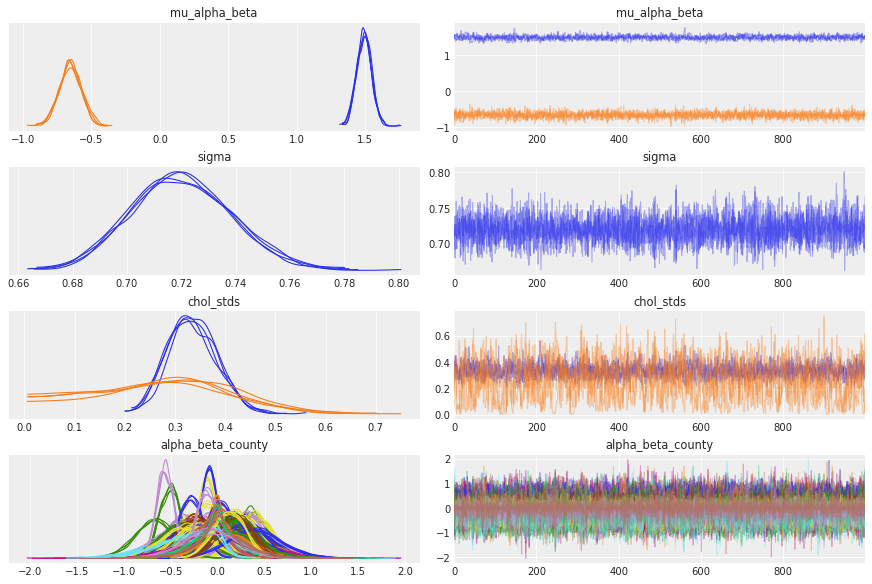

In [49]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names=["~z", "~chol", "~chol_corr"],
    compact=True,
    chain_prop={"ls": "-"},
);

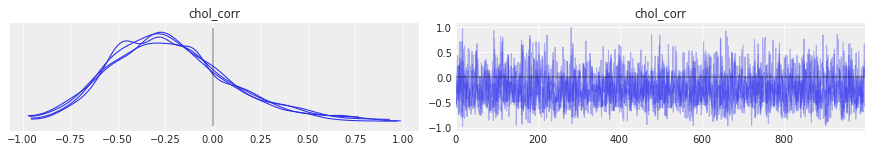

In [50]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names="chol_corr",
    lines=[("chol_corr", {}, 0.0)],
    compact=True,
    chain_prop={"ls": "-"},
    coords={
        "param": xr.DataArray(["alpha"], dims=["pointwise_sel"]),
        "param_bis": xr.DataArray(["beta"], dims=["pointwise_sel"]),
    },
);

So the correlation between slopes and intercepts seems to be negative: when the county intercept increases, the county slope tends to decrease. In other words, when basement radon in a county gets bigger, the difference with floor radon tends to get bigger too (because floor readings get smaller while basement readings get bigger). But again, the uncertainty is wide that it's possible the correlation goes the other way around or is simply close to zero. 

And how much variation is there across counties? It's not easy to read `sigma_ab` above, so let's do a forest plot and compare the estimates with the model that doesn't include the covariation between slopes and intercepts:

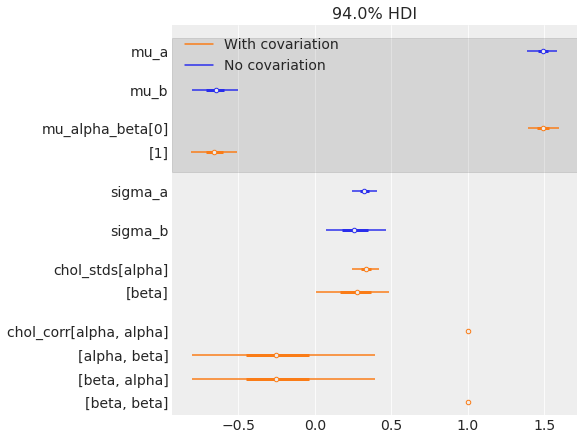

In [51]:
az.plot_forest(
    [varying_intercept_slope_trace, covariation_intercept_slope_trace],
    model_names=["No covariation", "With covariation"],
    var_names=["mu_a", "mu_b", "mu_alpha_beta", "sigma_a", "sigma_b", "chol_stds", "chol_corr"],
    combined=True,
    figsize=(8, 6),
);

The estimates are very close to each other, both for the means and the standard deviations. But remember, the information given by the correlation is only seen at the county level: in theory it uses even more information from the data to get an even more informed pooling of information for all county parameters. So let's visually compare estimates of both models at the county level:

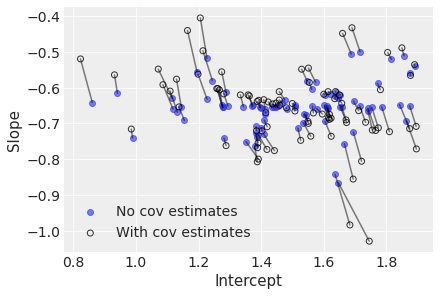

In [52]:
# posterior means of covariation model:
a_county_cov = (
    covariation_intercept_slope_trace.posterior['mu_alpha_beta'][..., 0]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="alpha")
).mean(dim=("chain", "draw"))
b_county_cov = (
    covariation_intercept_slope_trace.posterior['mu_alpha_beta'][..., 1]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="beta")
).mean(dim=("chain", "draw"))

# plot both and connect with lines
avg_a_county = noncentered_trace.posterior['alpha'].mean(dim=("chain", "draw"))
avg_b_county = noncentered_trace.posterior['beta'].mean(dim=("chain", "draw"))
plt.scatter(avg_a_county, avg_b_county, label="No cov estimates", alpha=0.6)
plt.scatter(
    a_county_cov,
    b_county_cov,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="With cov estimates",
    alpha=0.8,
)
plt.plot([avg_a_county, a_county_cov], [avg_b_county, b_county_cov], "k-", alpha=0.5)
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

The negative correlation is somewhat clear here: when the intercept increases, the slope decreases. So we understand why the model put most of the posterior weight into negative territory for the correlation term. Nevertheless, the model gives a non-trivial posterior probability to the possibility that the correlation could in fact be zero or positive.

Interestingly, the differences between both models occur at extreme slope and intercept values. This is because the second model used the slightly negative correlation between intercepts and slopes to adjust their estimates: when intercepts are *larger* (smaller) than average, the model pushes *down* (up) the associated slopes.

Globally, there is a lot of agreement here: modeling the correlation didn’t change inference that much. We already saw that radon levels tended to be lower in floors than basements, and when we checked the posterior distributions of the average effects (`alpha` and `beta`) and standard deviations, we noticed that they were almost identical. But on average the model with covariation will be more accurate -- because it squeezes additional information from the data, to shrink estimates in both dimensions.

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation, $\sigma_{\alpha}$ (here it would be the variation across counties, `sigma_a`). An important implication of this is that the group-level estimate induces stronger pooling -- by definition, a smaller $\sigma_{\alpha}$ means a stronger shrinkage of counties parameters towards the overall state mean. 

This is fairly straightforward to implement in PyMC -- we just add another level:

In [53]:
with pm.Model(coords=coords) as hierarchical_intercept:
    
    # Priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # County uranium model
    gamma_0 = pm.Normal('gamma_0', mu=0., sigma=10.)
    gamma_1 = pm.Normal('gamma_1', mu=0., sigma=10.)
    
    
    # Uranium model for intercept
    mu_a = pm.Deterministic('mu_a', gamma_0 + gamma_1*u)
    # County variation not explained by uranium
    epsilon_a = pm.Normal('epsilon_a', mu=0, sigma=1, dims='county')
    alpha = pm.Deterministic('alpha', mu_a + sigma_a*epsilon_a, dims='county')
    
    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = alpha[county] + beta * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    

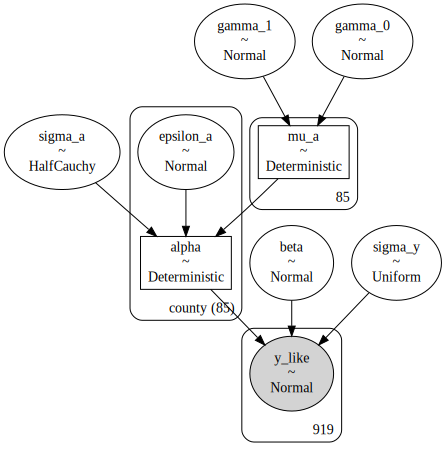

In [54]:
pm.model_to_graphviz(hierarchical_intercept)

Do you see the new level, with `sigma_a` and `gamma`, which is two-dimensional because it contains the linear model for `a_county`? 

In [55]:
with hierarchical_intercept:
    hierarchical_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, gamma_0, gamma_1, epsilon_a, beta, sigma_y]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


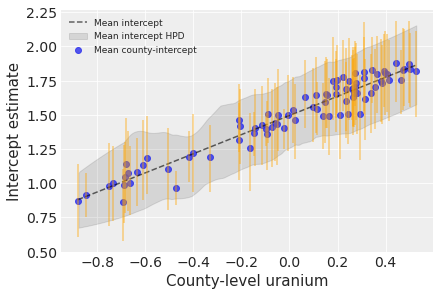

In [56]:
uranium = u
post = hierarchical_intercept_trace.posterior.assign_coords(uranium=uranium)
avg_a = post["mu_a"].mean(dim=("chain", "draw")).values[np.argsort(uranium)]
avg_a_county = post["alpha"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="alpha")["alpha"]

_, ax = plt.subplots()
ax.plot(uranium[np.argsort(uranium)], avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    uranium,
    post["alpha"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange",
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

Uranium is indeed strongly associated with baseline radon levels in each county. The graph above shows the average relationship and its uncertainty: the baseline radon level in an average county as a function of uranium, as well as the 94% HPD of this radon level (dashed line and envelope). The blue points and orange bars represent the relationship between baseline radon and uranium, but now for each county. As you see, the uncertainty is bigger now, because it adds on top of the average uncertainty -- each county has its idyosyncracies after all.

If we compare the county-intercepts for this model with those of the partial-pooling model without a county-level covariate:The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

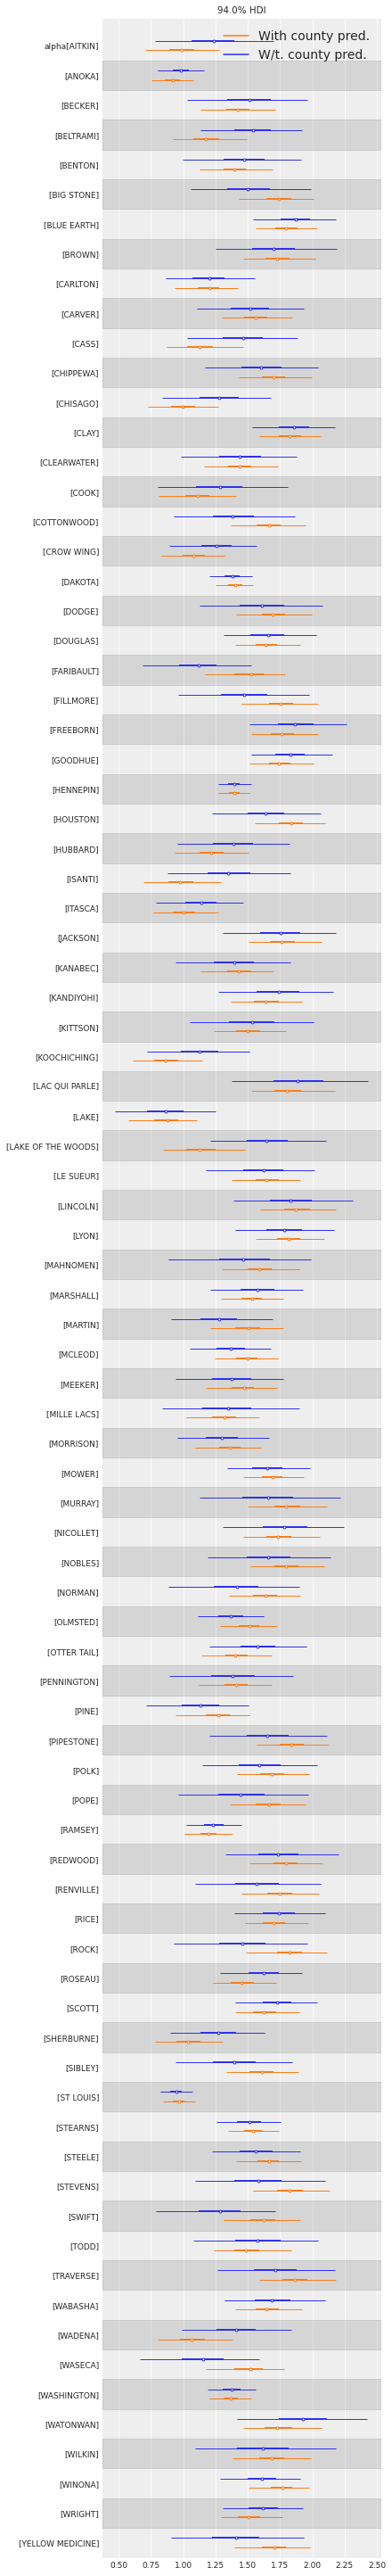

In [57]:
az.plot_forest(
    [varying_intercept_trace, hierarchical_intercept_trace],
    model_names=["W/t. county pred.", "With county pred."],
    var_names=["alpha"],
    combined=True,
    figsize=(6, 40),
    textsize=9,
);

We see that the compatibility intervals are narrower for the model including the county-level covariate. This is expected, as the effect of a covariate is to reduce the variation in the outcome variable -- provided the covariate is of predictive value. More importantly, with this model we were able to squeeze even more information out of the data.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

To add these effects to our model, let's create a new variable containing the mean of `floor` in each county and add that to our previous model:

In [58]:
# Create new variable for mean of floor across counties
avg_floor_data = srrs_mn.groupby('county')['floor'].mean().values

In [59]:
with pm.Model(coords=coords) as contextual_effect:
    floor_idx = pm.Data("floor_idx", floor_measure, mutable=True)
    county_idx = pm.Data("county_idx", county, mutable=True)
    y = pm.Data("y", log_radon, mutable=True)
    
    # Priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # County uranium model for slope
    gamma = pm.Normal('gamma', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    mu_a = pm.Deterministic('mu_a', gamma[0] + gamma[1]*u + gamma[2]*avg_floor_data)

    # County variation not explained by uranium
    epsilon_a = pm.Normal('epsilon_a', mu=0, sigma=1, dims='county')
    alpha = pm.Deterministic('alpha', mu_a + sigma_a*epsilon_a)

    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=10)
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=y)
    

In [60]:
with contextual_effect:
    contextual_effect_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, gamma, epsilon_a, beta, sigma_y]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


In [61]:
az.summary(contextual_effect_trace, var_names="gamma", round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],1.43,0.05,1.34,1.52,0.0,0.0,3657.71,2571.11,1.0
gamma[1],0.70,0.09,0.52,0.85,0.0,0.0,4361.60,2296.75,1.0
gamma[2],0.39,0.20,0.03,0.77,0.0,0.0,4311.11,2390.84,1.0


So we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. This seems to be new, as up to this point we saw that `floor` was *negatively* associated with radon levels. But remember this was at the household-level: radon tends to be higher in houses with basements. But at the county-level it seems that the less basements on average in the county, the more radon. So it's not that contradictory. What's more, the estimate for $\gamma_2$ is quite uncertain and overlaps with zero, so it's possible that the relationship is not that strong. And finally, let's note that $\gamma_2$ estimates something else than uranium's effect, as this is already taken into account by $\gamma_1$ -- it answers the question "once we know uranium level in the county, is there any value in learning about the proportion of houses without basements?".

All of this is to say that we shouldn't interpret this causally: there is no credible mechanism by which a basement (or absence thereof) *causes* radon emissions. More probably, our causal graph is missing something: a confounding variable, one that influences both basement construction and radon levels, is lurking somewhere in the dark... Perhaps is it the type of soil, which might influence what type of structures are built *and* the level of radon? Maybe adding this to our model would help with causal inference.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis and Kanabec counties, we just need to sample from the radon model with the appropriate intercept.

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

Because we judiciously set the county index and floor values as shared variables earlier, we can modify them directly to the desired values (69 and 1 respectively) and sample corresponding posterior predictions, without having to redefine and recompile our model. Using the model just above:

In [62]:
prediction_coords = {"obs_id": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data(
        {"county_idx": np.array([69, 31]), 
        "floor_idx": np.array([1, 1]),
        "y": np.ones(2)}
    )
    stl_pred = pm.sample_posterior_predictive(
        contextual_effect_trace.posterior
    )

contextual_effect_trace.extend(stl_pred)

Sampling: [y_like]


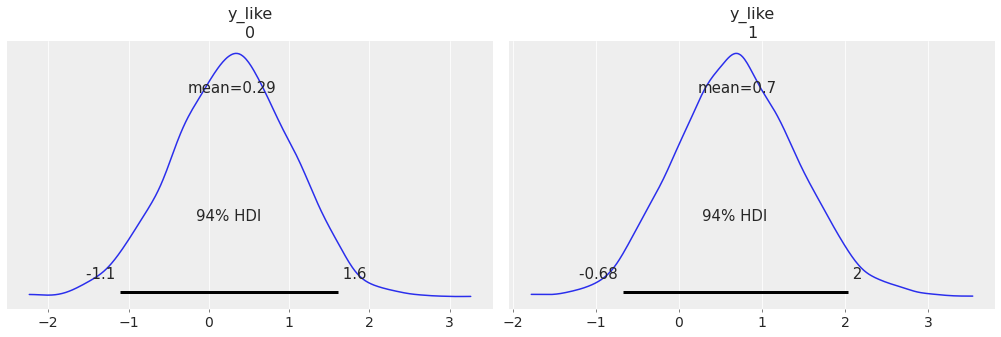

In [63]:
az.plot_posterior(contextual_effect_trace, group='posterior_predictive');

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data.

- Estimation of coefficients for (under-represented) groups.

- Incorporating individual- and group-level information when estimating group-level coefficients.

- Allowing for variation among individual-level coefficients across groups.

## References

:::{bibliography}
:filter: docname in docnames

gelman2006multilevel
mcelreath2018statistical
:::

## Authors

* Authored by Chris Fonnesbeck in May, 2017 ([pymc#2124](https://github.com/pymc-devs/pymc/pull/2124))
* Updated by Colin Carroll in June, 2018 ([pymc#3049](https://github.com/pymc-devs/pymc/pull/3049))
* Updated by Alex Andorra in January, 2020 ([pymc#3765](https://github.com/pymc-devs/pymc/pull/3765))
* Updated by Oriol Abril in June, 2020 ([pymc#3963](https://github.com/pymc-devs/pymc/pull/3963))
* Updated by Farhan Reynaldo in November 2021 ([pymc-examples#246](https://github.com/pymc-devs/pymc-examples/pull/246))
* Updated by Chris Fonnesbeck in Februry 2022 ([pymc-examples#285](https://github.com/pymc-devs/pymc-examples/pull/285))
* Updated by Chris Fonnesbeck in November 2022

## Watermark

In [64]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 17 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

numpy     : 1.22.4
xarray    : 2022.3.0
matplotlib: 3.5.2
seaborn   : 0.11.2
aesara    : 2.8.7
pandas    : 1.4.2
pymc      : 4.3.0
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:39:37) [Clang 12.0.1 ]
arviz     : 0.13.0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::